In [38]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import optuna
import logging
from tqdm import tqdm

In [5]:
def prepare_data(df):
    """
    Prepare the data for modeling by creating necessary features and encoding
    """
    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
        
    # Create copy of DataFrame with date as column for Prophet
    df = df.copy()
    df['date'] = df.index
    
    # Create time-based features
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.isocalendar().week
    
    # Create seasonality features
    df['quarter'] = df.index.quarter
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    
    # One-hot encode day_of_week if it exists as categorical
    if 'day_of_week' in df.columns and df['day_of_week'].dtype == 'O':
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        day_of_week_encoded = encoder.fit_transform(df[['day_of_week']])
        day_of_week_cols = [f'day_{i}' for i in range(day_of_week_encoded.shape[1])]
        df[day_of_week_cols] = day_of_week_encoded
        df.drop('day_of_week', axis=1, inplace=True)
        
    # Convert is_holiday to numeric if it isn't already
    if 'is_holiday' in df.columns and df['is_holiday'].dtype == 'O':
        df['is_holiday'] = df['is_holiday'].astype(int)
    return df

In [6]:
def create_recurring_holidays(df):
    """
    Create a DataFrame of recurring holidays from historical data
    """
    # Get dates that are holidays
    holiday_dates = df[df['is_holiday'] == 1]['date']
    # Extract month and day for each holiday
    holiday_patterns = pd.DataFrame({
    'month': holiday_dates.dt.month,
    'day': holiday_dates.dt.day
    }).drop_duplicates()
    # Create holidays for the forecast period
    last_date = df.index.max()
    forecast_end = last_date + pd.DateOffset(months=4) # Add buffer for forecast period
    all_holidays = []
    for year in range(df.index.min().year, forecast_end.year + 1):
        for _, holiday in holiday_patterns.iterrows():
            try:
                holiday_date = pd.Timestamp(year=year, month=holiday['month'], day=holiday['day'])
                all_holidays.append(holiday_date)
            except ValueError:
                continue # Skip invalid dates (e.g., Feb 29 in non-leap years)
    holidays_df = pd.DataFrame({
        'ds': all_holidays,
        'holiday': 'recurring_holiday',
        'lower_window': 0,
        'upper_window': 0
        })
    return holidays_df

In [77]:
# Suppress unnecessary logs
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)
logging.getLogger('prophet').setLevel(logging.CRITICAL)
logging.getLogger('optuna').setLevel(logging.WARNING)

def train_prophet_model(df, cv=True, n_trials=100):
    """
    Train a Prophet model using Optuna for hyperparameter optimization.
    """
    # Prepare data for Prophet
    prophet_df = df[['date', 'total_calls']].rename(columns={
        'date': 'ds',
        'total_calls': 'y'
    })

    def objective(trial):
        """Objective function for Optuna to minimize."""
        # Suggest hyperparameters
        yearly_seasonality = trial.suggest_int("yearly_seasonality", 10, 25, step=5)
        weekly_seasonality = trial.suggest_int("weekly_seasonality", 5, 12, step=1)
        daily_seasonality = trial.suggest_categorical("daily_seasonality", [True, False])
        holidays_prior_scale = trial.suggest_float("holidays_prior_scale", 1, 15, log=True)
        seasonality_prior_scale = trial.suggest_float("seasonality_prior_scale", 1, 15, log=True)
        seasonality_mode = trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"])
        changepoint_prior_scale = trial.suggest_float("changepoint_prior_scale", 0.001, 0.5, log=True)
        changepoint_range = trial.suggest_float("changepoint_range", 0.8, 1.0)

        # Create holidays DataFrame if applicable
        holidays_df = create_recurring_holidays(df) if 'is_holiday' in df.columns else None

        # Time series cross-validation
        tscv = TimeSeriesSplit(n_splits=5)
        cv_results = []

        for train_index, test_index in tscv.split(prophet_df):
            # Create a new Prophet instance for each fold
            model = Prophet(
                yearly_seasonality=yearly_seasonality,
                weekly_seasonality=weekly_seasonality,
                daily_seasonality=daily_seasonality,
                holidays=holidays_df,
                holidays_prior_scale=holidays_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale,
                seasonality_mode=seasonality_mode,
                changepoint_prior_scale=changepoint_prior_scale,
                changepoint_range=changepoint_range
            )

            train_df = prophet_df.iloc[train_index]
            test_df = prophet_df.iloc[test_index]

            # Fit the model on the training set
            model.fit(train_df)

            # Predict on the test set
            forecast = model.predict(test_df)

            # Calculate MSE
            mse = np.mean((test_df['y'].values - forecast['yhat'].values) ** 2)
            cv_results.append(mse)

        # Return average MSE across folds
        return np.mean(cv_results)

    if cv:
        # Use Optuna to find the best hyperparameters
        study = optuna.create_study(direction="minimize")
        for _ in tqdm(range(n_trials), desc="Optuna trials"):
            study.optimize(objective, n_trials=1, show_progress_bar=False)

        # Print best parameters
        print("Best Parameters:", study.best_params)
        print("Best Cross-Validation MSE:", study.best_value)

        # Retrain the final model with the best parameters
        best_params = study.best_params
        final_model = Prophet(
            yearly_seasonality=best_params['yearly_seasonality'],
            weekly_seasonality=best_params['weekly_seasonality'],
            daily_seasonality=best_params['daily_seasonality'],
            holidays=create_recurring_holidays(df) if 'is_holiday' in df.columns else None,
            holidays_prior_scale=best_params['holidays_prior_scale'],
            seasonality_prior_scale=best_params['seasonality_prior_scale'],
            seasonality_mode=best_params['seasonality_mode'],
            changepoint_prior_scale=best_params['changepoint_prior_scale'],
            changepoint_range=best_params['changepoint_range']
        )
        final_model.fit(prophet_df)

        return final_model

# Usage example (assuming `df` is your DataFrame with 'date' and 'total_calls' columns):
# model = train_prophet_model_with_optuna(df, n_trials=50)


In [78]:
def train_xgboost_model(df):
    """
    Train an XGBoost model with hyperparameter tuning using time series cross-validation
    """
    # Ensure 'date' column is converted to timestamp
    if 'date' in df.columns:
        df['date'] = df['date'].apply(lambda x: x.timestamp())
    
    # Prepare features
    feature_cols = df.columns.tolist()
    
    # Remove target column from features
    feature_cols.remove('total_calls')
    
    X = df[feature_cols]
    y = df['total_calls']
    
    # Define the base model
    base_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    )
    
    # Define parameter grid for tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 2, 3],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    
    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Grid search with time series cross-validation
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X, y)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Print best parameters for reference
    print("Best Parameters:", grid_search.best_params_)
    
    # Optional: Feature importance
    feature_importance = best_model.feature_importances_
    feature_importance_dict = dict(zip(feature_cols, feature_importance))
    print("\nFeature Importance:")
    for feature, importance in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True):
        print(f"{feature}: {importance}")
    
    return best_model, feature_cols

In [79]:
def generate_future_dates(last_date, periods):
    """
    Generate future dates for prediction
    """
    future_dates = pd.date_range(
        start=last_date + timedelta(days=1),
        periods=periods,
        freq='D'
    )
    return future_dates

In [80]:
def make_predictions(df, forecast_days=90):
    """
    Make predictions using optimized Prophet and XGBoost models
    """
    # Prepare data with enhanced features
    df_prepared = prepare_data(df)
    
    # Train Prophet model with cross-validation
    prophet_model = train_prophet_model(df_prepared)
    
    # Generate future dates for Prophet
    future_dates = generate_future_dates(df_prepared['date'].max(), forecast_days)
    future_df = pd.DataFrame({'ds': future_dates})
    
    # Make Prophet predictions
    prophet_forecast = prophet_model.predict(future_df)
    
    # Train XGBoost model
    xgb_model, feature_cols = train_xgboost_model(df_prepared)
    
    # Prepare future data for XGBoost
    future_features = pd.DataFrame(index=future_dates)
    future_features['date'] = future_dates
    future_features['month'] = future_dates.month
    future_features['year'] = future_dates.year
    future_features['day_of_month'] = future_dates.day
    future_features['week_of_year'] = future_dates.isocalendar().week
    future_features['quarter'] = future_dates.quarter
    future_features['month_sin'] = np.sin(2 * np.pi * future_dates.month / 12)
    future_features['month_cos'] = np.cos(2 * np.pi * future_dates.month / 12)
    future_features['day_of_week_sin'] = np.sin(2 * np.pi * future_dates.dayofweek / 7)
    future_features['day_of_week_cos'] = np.cos(2 * np.pi * future_dates.dayofweek / 7)
    
    # Define Armenian holidays 
    armenian_holidays = [
    '2025-01-01','2026-01-01',
    '2025-01-02','2026-01-02',
    '2025-01-06','2026-01-06',
    '2025-01-28','2026-01-28',
    '2025-03-08','2026-03-08',
    '2025-04-24','2026-04-24',
    '2025-05-01','2026-05-01',
    '2025-05-09','2026-05-09',
    '2025-05-28','2026-05-28',
    '2025-07-05','2026-07-05',
    '2025-09-21','2026-09-21',
    '2025-12-31','2026-12-31',
]
    
    # Add holiday column
    future_features["is_holiday"] = future_features.index.isin(armenian_holidays)
    
    # Additional features to predict
    additional_features = [
        'working_time', 'number_of_unique_logins', 'clients',
        'missed_calls', 'unique_numbers', 'Call duration',
        'time_to_next_call', 'calls_from_clients',  'number_of_new_clients',
        'number_of_new_clients_last_7_days', 'number_of_new_clients_last_30_days'
    ]
    
    df['date'] = df.index
    
    # Predict additional features with optimized Prophet models
    for feature in additional_features:
        if feature in df.columns:
            # Predict using optimized Prophet model
            prophet_df = df[['date', feature]].rename(columns={
                'date': 'ds',
                feature: 'y'
            })
            
            # Use the same tuning approach as main model
            model = train_prophet_model(
                prophet_df.rename(columns={'ds': 'date', 'y': 'total_calls'}), 

            )
            
            # Forecast the feature
            future_feature_forecast = model.predict(future_df)
            future_features[feature] = future_feature_forecast['yhat'].to_list()
    
    # Add one-hot encoded day of week
    day_cols = [col for col in feature_cols if col.startswith('day_') and col != 'day_of_month']
    if day_cols:
        for col in day_cols:
            future_features[col] = 0
        for i, date in enumerate(future_dates):
            day_num = date.dayofweek
            if f'day_{day_num}' in day_cols:
                future_features.loc[future_features.index[i], f'day_{day_num}'] = 1
    
    # Convert date to timestamp
    future_features['date'] = future_features['date'].apply(lambda x: x.timestamp())
    
    # Make XGBoost predictions
    xgb_forecast = xgb_model.predict(future_features[feature_cols])
    
    # Combine predictions with weighted ensemble
    weights = np.linspace(0.4, 0.6, forecast_days)
    final_forecast = pd.DataFrame({
        'date': future_dates,
        'prophet_forecast': prophet_forecast['yhat'],
        'xgboost_forecast': xgb_forecast,
        'ensemble_forecast': weights * prophet_forecast['yhat'] + (1 - weights) * xgb_forecast
    })
    
    return final_forecast

In [81]:
def evaluate_models(df):
    """
    Evaluate model performance using historical data
    """
    # Use last 30 days as test set
    test_size = 30
    train_df = df[:-test_size]
    test_df = df[-test_size:]
    
    # Make predictions
    forecast = make_predictions(train_df, forecast_days=test_size)
    
    # Calculate metrics
    actual_values = test_df['total_calls'].values
    predicted_values = forecast['ensemble_forecast'].values
    
    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    
    return mae, rmse, mape

In [82]:
# Load data
df = pd.read_excel('calls.xlsx', parse_dates=['Date'], index_col='Date')
df = df.sort_index()
df = df.drop(columns=['Unnamed: 0','share_of_answered_calls',
        'share_of_calls_from_registered_number','answered_calls'])

In [83]:
df["day_of_week"] = df.index.day_name()

In [90]:
numerical_cols = df.select_dtypes(include=['number']).columns

# Fill NaN values in numerical columns with their respective means
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

In [92]:
# Define Armenian holidays 
armenian_holidays = [
    '2022-01-01','2023-01-01','2024-01-01','2025-01-01','2026-01-01',
    '2022-01-02','2023-01-02','2024-01-02','2025-01-02','2026-01-02',
    '2022-01-06','2023-01-06','2024-01-06','2025-01-06','2026-01-06',
    '2022-01-28','2023-01-28','2024-01-28','2025-01-28','2026-01-28',
    '2022-03-08','2023-03-08','2024-03-08','2025-03-08','2026-03-08',
    '2022-04-24','2023-04-24','2024-04-24','2025-04-24','2026-04-24',
    '2022-05-01','2023-05-01','2024-05-01','2025-05-01','2026-05-01',
    '2022-05-09','2023-05-09','2024-05-09','2025-05-09','2026-05-09',
    '2022-05-28','2023-05-28','2024-05-28','2025-05-28','2026-05-28',
    '2022-07-05','2023-07-05','2024-07-05','2025-07-05','2026-07-05',
    '2022-09-21','2023-09-21','2024-09-21','2025-09-21','2026-09-21',
    '2022-12-31','2023-12-31','2024-12-31','2025-12-31','2026-12-31',
]
armenian_holidays = pd.to_datetime(armenian_holidays)
# Add a column to indicate if the date is a holiday
df["is_holiday"] = df.index.isin(armenian_holidays)

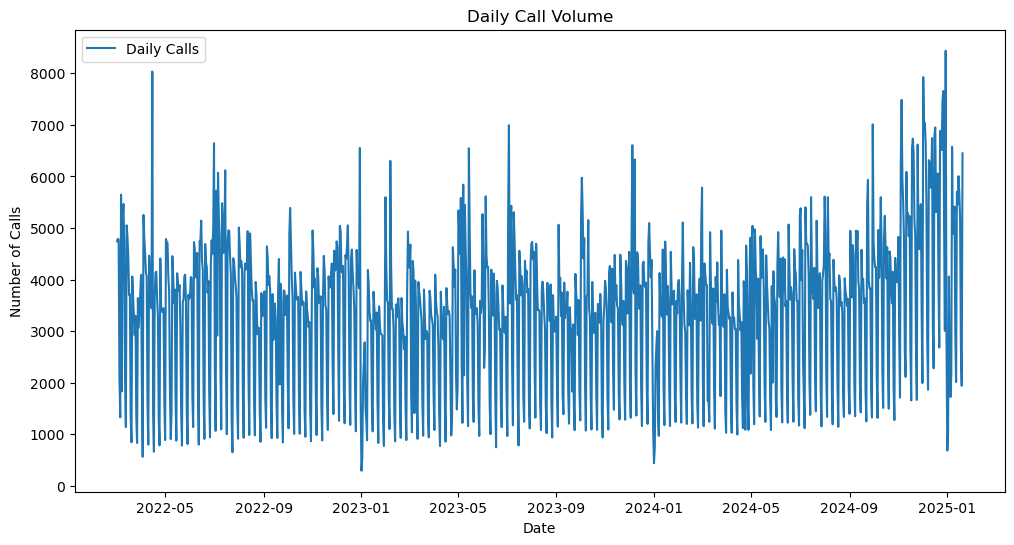

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(df['total_calls'], label='Daily Calls')
plt.title('Daily Call Volume')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.legend()
plt.show()

In [94]:
df.index = pd.to_datetime(df.index)

In [95]:
# df.tail(10)

In [96]:
results = make_predictions(df, forecast_days=90)

Optuna trials:   0%|          | 0/100 [00:00<?, ?it/s]

Optuna trials: 100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


Best Parameters: {'yearly_seasonality': 25, 'weekly_seasonality': 7, 'daily_seasonality': True, 'holidays_prior_scale': 2.15674592140966, 'seasonality_prior_scale': 1.243049206002946, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.015724131046628186, 'changepoint_range': 0.894427404090469}
Best Cross-Validation MSE: 846817.8889767077
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


C:\Users\Karen A. Margaryan\AppData\Local\Temp\14\ipykernel_16276\1284638507.py:51: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  future_features["is_holiday"] = future_features.index.isin(armenian_holidays)


Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.6}

Feature Importance:
calls_from_clients: 0.3670923709869385
day_2: 0.2133067548274994
unique_numbers: 0.1899218112230301
number_of_new_clients: 0.10557378083467484
day_of_week_sin: 0.037008337676525116
missed_calls: 0.030259639024734497
time_to_next_call: 0.010999063961207867
year: 0.009050562046468258
date: 0.008586414158344269
number_of_unique_logins: 0.005564600229263306
clients: 0.003916431684046984
day_of_month: 0.0030532327946275473
Call duration: 0.0025472710840404034
working_time: 0.0018099535955116153
number_of_new_clients_last_7_days: 0.0018065073527395725
month_cos: 0.0014573553344234824
month: 0.0013397298753261566
day_4: 0.0012927863281220198
week_of_year: 0.0009069396182894707
number_of_new_clients_last_30_days: 0.0008330626296810806
day_3: 0.0007536998600699008
day_5: 0.0007003616192378104
day_of_week_cos: 0.0006493749096989632
mo

Optuna trials: 100%|██████████| 100/100 [01:50<00:00,  1.10s/it]


Best Parameters: {'yearly_seasonality': 10, 'weekly_seasonality': 7, 'daily_seasonality': False, 'holidays_prior_scale': 6.384734520999306, 'seasonality_prior_scale': 9.316123458585611, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.0020765317039134605, 'changepoint_range': 0.9720691218796969}
Best Cross-Validation MSE: 0.5358617734211243


Optuna trials: 100%|██████████| 100/100 [05:24<00:00,  3.24s/it]


Best Parameters: {'yearly_seasonality': 20, 'weekly_seasonality': 6, 'daily_seasonality': True, 'holidays_prior_scale': 1.1657383988164463, 'seasonality_prior_scale': 1.131533294521333, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001751804903111226, 'changepoint_range': 0.969299756211459}
Best Cross-Validation MSE: 67.92102122454028


Optuna trials: 100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


Best Parameters: {'yearly_seasonality': 15, 'weekly_seasonality': 5, 'daily_seasonality': False, 'holidays_prior_scale': 2.2145927404958003, 'seasonality_prior_scale': 2.5493870744377873, 'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.008434108957798237, 'changepoint_range': 0.9433963478834357}
Best Cross-Validation MSE: 193352860.7294292


Optuna trials: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Best Parameters: {'yearly_seasonality': 15, 'weekly_seasonality': 6, 'daily_seasonality': False, 'holidays_prior_scale': 4.900357859682135, 'seasonality_prior_scale': 5.551806283377011, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.026051074147563486, 'changepoint_range': 0.9958576965087047}
Best Cross-Validation MSE: 578543.6814881985


Optuna trials: 100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


Best Parameters: {'yearly_seasonality': 25, 'weekly_seasonality': 5, 'daily_seasonality': True, 'holidays_prior_scale': 1.3560872118638634, 'seasonality_prior_scale': 12.259004235975512, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.00672117734173868, 'changepoint_range': 0.8257563813218489}
Best Cross-Validation MSE: 263780.9439310256


Optuna trials: 100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Best Parameters: {'yearly_seasonality': 20, 'weekly_seasonality': 12, 'daily_seasonality': False, 'holidays_prior_scale': 10.308993845472859, 'seasonality_prior_scale': 6.814995381840583, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.020931013090769487, 'changepoint_range': 0.873272875880092}
Best Cross-Validation MSE: 0.043636206476904756


Optuna trials: 100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


Best Parameters: {'yearly_seasonality': 20, 'weekly_seasonality': 5, 'daily_seasonality': True, 'holidays_prior_scale': 14.661294502601589, 'seasonality_prior_scale': 11.804800969467122, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.00110048275034999, 'changepoint_range': 0.9192165236030359}
Best Cross-Validation MSE: 0.5450205544189857


Optuna trials: 100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


Best Parameters: {'yearly_seasonality': 25, 'weekly_seasonality': 9, 'daily_seasonality': True, 'holidays_prior_scale': 6.437403597397205, 'seasonality_prior_scale': 3.9673241151148817, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.0395501796918894, 'changepoint_range': 0.8769680649255651}
Best Cross-Validation MSE: 518004.59777614864


Optuna trials: 100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


Best Parameters: {'yearly_seasonality': 10, 'weekly_seasonality': 6, 'daily_seasonality': False, 'holidays_prior_scale': 1.990792052573785, 'seasonality_prior_scale': 8.440789470017501, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.06092800993264065, 'changepoint_range': 0.8918787517783688}
Best Cross-Validation MSE: 111811.70498832897


Optuna trials: 100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


Best Parameters: {'yearly_seasonality': 20, 'weekly_seasonality': 9, 'daily_seasonality': True, 'holidays_prior_scale': 1.1973061492214838, 'seasonality_prior_scale': 13.200366187782945, 'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.052471081140211984, 'changepoint_range': 0.8359762636295495}
Best Cross-Validation MSE: 4420590.842600553


Optuna trials: 100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


Best Parameters: {'yearly_seasonality': 10, 'weekly_seasonality': 9, 'daily_seasonality': True, 'holidays_prior_scale': 1.868495097257445, 'seasonality_prior_scale': 1.0654703831133545, 'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03244037395559038, 'changepoint_range': 0.9728577973895984}
Best Cross-Validation MSE: 64020458.89228892


In [97]:
# Assuming your data is in a pandas DataFrame called 'df' with a datetime index

mae, rmse, mape = evaluate_models(df)
print(f"Model Performance Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

Optuna trials: 100%|██████████| 100/100 [02:21<00:00,  1.42s/it]


Best Parameters: {'yearly_seasonality': 20, 'weekly_seasonality': 7, 'daily_seasonality': True, 'holidays_prior_scale': 3.337067328010088, 'seasonality_prior_scale': 2.9894493921876104, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.017642089934188233, 'changepoint_range': 0.9771978729193225}
Best Cross-Validation MSE: 657228.4549203773
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


C:\Users\Karen A. Margaryan\AppData\Local\Temp\14\ipykernel_16276\1284638507.py:51: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  future_features["is_holiday"] = future_features.index.isin(armenian_holidays)
C:\Users\Karen A. Margaryan\AppData\Local\Temp\14\ipykernel_16276\1284638507.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index


Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}

Feature Importance:
calls_from_clients: 0.3694518208503723
day_of_week_sin: 0.30935588479042053
unique_numbers: 0.20007722079753876
date: 0.03997659683227539
missed_calls: 0.029016979038715363
year: 0.01618015021085739
clients: 0.011330939829349518
number_of_new_clients: 0.00989295169711113
number_of_unique_logins: 0.00460761459544301
time_to_next_call: 0.0014097009552642703
working_time: 0.001285366714000702
number_of_new_clients_last_30_days: 0.0010811085812747478
day_of_month: 0.0008730061817914248
quarter: 0.0008421201491728425
Call duration: 0.0008078310056589544
month: 0.0007968186982907355
day_of_week_cos: 0.0005254122661426663
number_of_new_clients_last_7_days: 0.0003936685679946095
day_0: 0.0003780985134653747
week_of_year: 0.00034368623164482415
day_5: 0.00033355847699567676
month_sin: 0.0003315950743854046
month_cos: 0.00028865531203

Optuna trials: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


Best Parameters: {'yearly_seasonality': 10, 'weekly_seasonality': 7, 'daily_seasonality': True, 'holidays_prior_scale': 7.632470164310668, 'seasonality_prior_scale': 1.2013299437926022, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.0010608983855310305, 'changepoint_range': 0.9669250642244225}
Best Cross-Validation MSE: 0.45967839740242233


Optuna trials: 100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


Best Parameters: {'yearly_seasonality': 10, 'weekly_seasonality': 12, 'daily_seasonality': False, 'holidays_prior_scale': 14.979203160802836, 'seasonality_prior_scale': 4.435496475086447, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.004720976774159371, 'changepoint_range': 0.9926706897396956}
Best Cross-Validation MSE: 68.4663079848232


Optuna trials: 100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


Best Parameters: {'yearly_seasonality': 10, 'weekly_seasonality': 8, 'daily_seasonality': False, 'holidays_prior_scale': 2.4391050332810176, 'seasonality_prior_scale': 1.1229339886443976, 'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.00101647980056875, 'changepoint_range': 0.8407116068767381}
Best Cross-Validation MSE: 269361226.6309714


Optuna trials: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Best Parameters: {'yearly_seasonality': 20, 'weekly_seasonality': 8, 'daily_seasonality': True, 'holidays_prior_scale': 1.6490018145702787, 'seasonality_prior_scale': 1.1573705703020294, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.015232008106360839, 'changepoint_range': 0.8963639048094699}
Best Cross-Validation MSE: 478958.4552896869


Optuna trials: 100%|██████████| 100/100 [03:45<00:00,  2.26s/it]


Best Parameters: {'yearly_seasonality': 25, 'weekly_seasonality': 9, 'daily_seasonality': True, 'holidays_prior_scale': 14.258940949110317, 'seasonality_prior_scale': 7.07599577371764, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.007976272927633268, 'changepoint_range': 0.9133368784093344}
Best Cross-Validation MSE: 217978.51964087467


Optuna trials: 100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


Best Parameters: {'yearly_seasonality': 10, 'weekly_seasonality': 11, 'daily_seasonality': False, 'holidays_prior_scale': 2.5752595043806443, 'seasonality_prior_scale': 10.252052954202949, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.0017217439836431773, 'changepoint_range': 0.9571236438897309}
Best Cross-Validation MSE: 0.06155837765257364


Optuna trials: 100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Best Parameters: {'yearly_seasonality': 20, 'weekly_seasonality': 12, 'daily_seasonality': True, 'holidays_prior_scale': 1.5736625709155319, 'seasonality_prior_scale': 2.408948170961789, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.005122990002471725, 'changepoint_range': 0.8430839648532163}
Best Cross-Validation MSE: 0.6835398831937521


Optuna trials: 100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


Best Parameters: {'yearly_seasonality': 10, 'weekly_seasonality': 12, 'daily_seasonality': True, 'holidays_prior_scale': 10.139425945703946, 'seasonality_prior_scale': 8.319330962429174, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.028550914162797016, 'changepoint_range': 0.9650124160954927}
Best Cross-Validation MSE: 439161.99293899303


Optuna trials: 100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Best Parameters: {'yearly_seasonality': 10, 'weekly_seasonality': 5, 'daily_seasonality': False, 'holidays_prior_scale': 3.54913560577148, 'seasonality_prior_scale': 9.856175272795657, 'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.17071517846449197, 'changepoint_range': 0.8657741130145441}
Best Cross-Validation MSE: 89297.2742181076


Optuna trials: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]


Best Parameters: {'yearly_seasonality': 10, 'weekly_seasonality': 5, 'daily_seasonality': True, 'holidays_prior_scale': 5.710683122946763, 'seasonality_prior_scale': 4.250027000577697, 'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.02343762407997363, 'changepoint_range': 0.9472108524466759}
Best Cross-Validation MSE: 3085895.0845873123


Optuna trials: 100%|██████████| 100/100 [03:22<00:00,  2.02s/it]


Best Parameters: {'yearly_seasonality': 20, 'weekly_seasonality': 12, 'daily_seasonality': True, 'holidays_prior_scale': 3.607981232639883, 'seasonality_prior_scale': 2.953251810514163, 'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.030702723665259408, 'changepoint_range': 0.9382885338208887}
Best Cross-Validation MSE: 33272678.822495125
Model Performance Metrics:
MAE: 1215.04
RMSE: 1580.84
MAPE: 50.74%


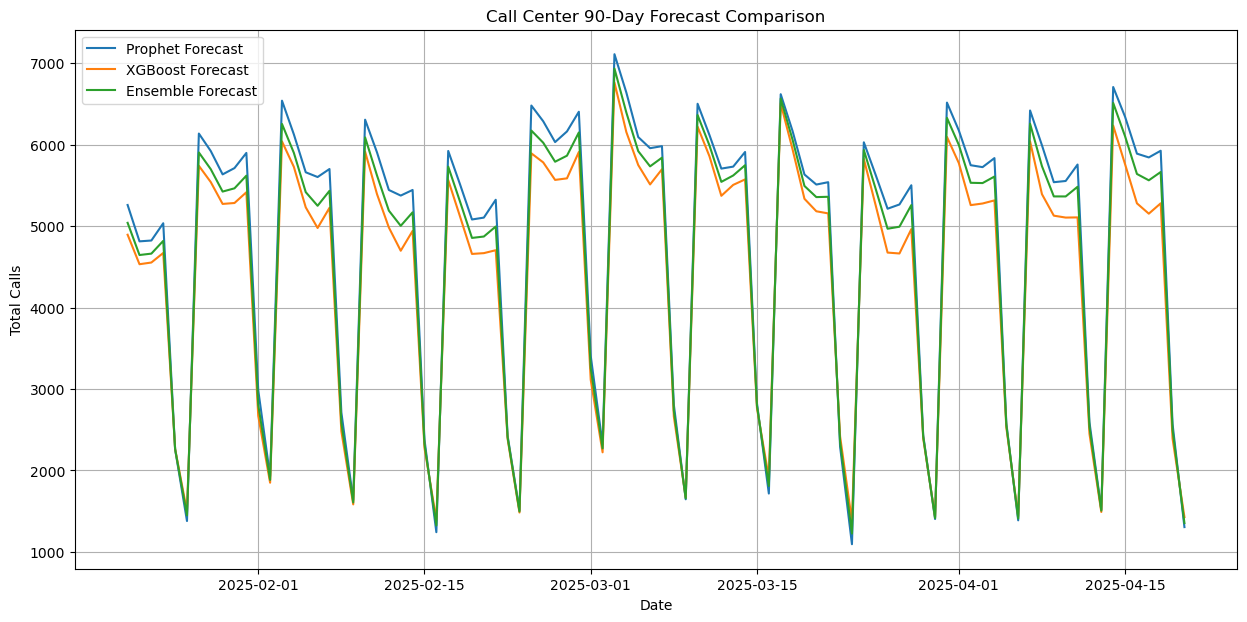

In [98]:
plt.figure(figsize=(15, 7))
plt.plot(results['date'], results['prophet_forecast'], label='Prophet Forecast')
plt.plot(results['date'], results['xgboost_forecast'], label='XGBoost Forecast')
plt.plot(results['date'], results['ensemble_forecast'], label='Ensemble Forecast')
plt.title('Call Center 90-Day Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Total Calls')
plt.legend()
plt.grid(True)
plt.show()

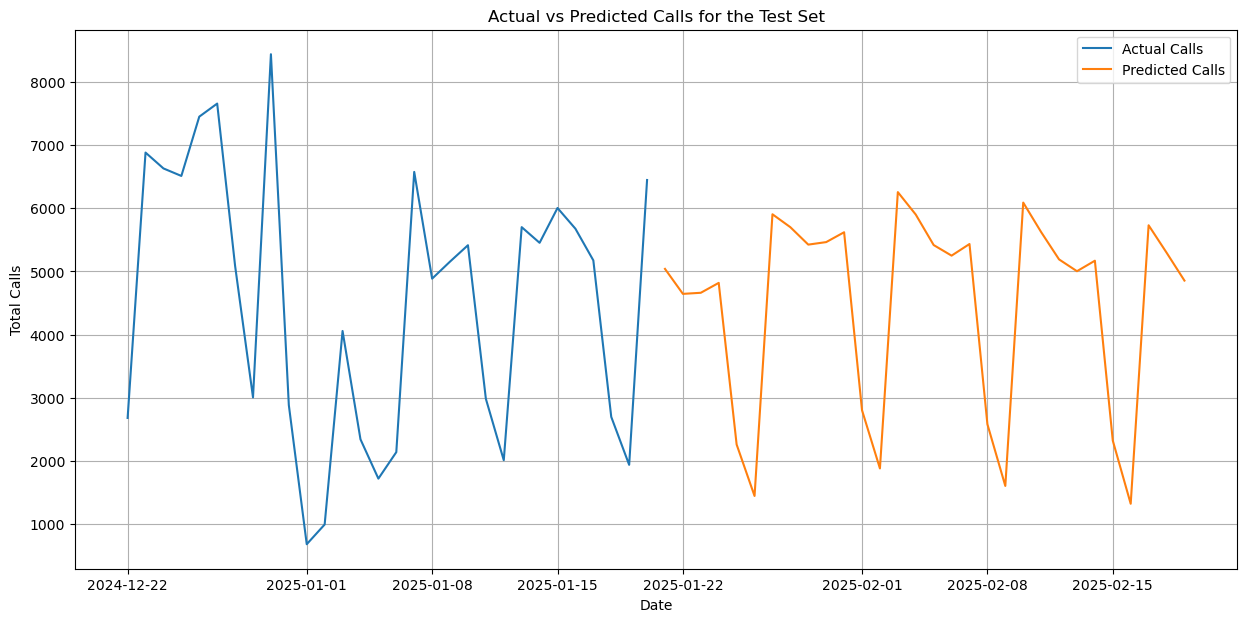

In [99]:
# Plot actual vs predicted values for the test set
plt.figure(figsize=(15, 7))
plt.plot(df.index[-30:], df['total_calls'][-30:], label='Actual Calls')
plt.plot(results['date'][:30], results['ensemble_forecast'][:30], label='Predicted Calls')
plt.title('Actual vs Predicted Calls for the Test Set')
plt.xlabel('Date')
plt.ylabel('Total Calls')
plt.legend()
plt.grid(True)
plt.show()

In [100]:
results

,date,prophet_forecast,xgboost_forecast,ensemble_forecast
0,2025-01-21,5259.750726,4894.448730,5040.569529
1,2025-01-22,4813.130568,4532.280273,4645.251516
2,2025-01-23,4823.325157,4553.153809,4662.436601
3,2025-01-24,5035.473072,4670.576660,4818.995201
4,2025-01-25,2259.505300,2263.288818,2261.741402
...,...,...,...,...
85,2025-04-16,5890.305742,5280.093750,5640.735894
86,2025-04-17,5843.863588,5153.103516,5562.902750
87,2025-04-18,5925.954711,5280.119141,5664.717851
88,2025-04-19,2569.331350,2390.548584,2497.416485


In [101]:
results['ensemble_forecast'][:30].sum()

134731.04820729033

In [102]:
results['ensemble_forecast'][30:60].sum()

147229.07977675842

In [103]:
results['ensemble_forecast'][60:].sum()

132565.38903112465

In [104]:
results.to_csv("results.csv", index=False)